In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [68]:
df = pd.read_csv('ndt_tests_corrigido.csv')

df.head()

,timestamp,download_throughput_bps,rtt_download_sec,upload_throughput_bps,rtt_upload_sec,packet_loss_percent,client,server
0,2025-08-09 15:28:02.000 +0000,8.223657e+07,0.231862,6.973217e+07,0.247727,0.000000,client12,server06
1,2025-08-09 15:30:11.000 +0000,9.027315e+08,0.012000,8.521780e+08,0.005423,0.008226,client01,server07
2,2025-08-10 04:27:43.000 +0000,5.910655e+08,0.014000,2.812188e+08,0.014544,5.954284,client13,server07
3,2025-08-09 22:45:07.000 +0000,6.721139e+08,0.011000,1.135400e+08,0.010482,0.261528,client12,server07
4,2025-08-10 04:49:21.000 +0000,8.122087e+08,0.009000,6.857905e+08,0.009368,1.381646,client03,server03


# Analyzing the data


In [69]:
df.describe()

,download_throughput_bps,rtt_download_sec,upload_throughput_bps,rtt_upload_sec,packet_loss_percent
count,7.087000e+03,7087.000000,7.087000e+03,7087.000000,7087.000000
mean,5.062996e+08,0.048447,3.781607e+08,0.037194,1.899137
std,3.352129e+08,0.067859,3.014096e+08,0.063537,3.449941
min,-1.000000e+00,-0.001000,-1.000000e+00,-1.000000,-1.000000
25%,1.642170e+08,0.008000,9.733497e+07,0.004918,0.001484
50%,5.960927e+08,0.011549,2.979242e+08,0.010858,0.189771
75%,8.489080e+08,0.115000,6.701694e+08,0.017723,2.050781
max,9.332671e+08,0.398051,9.214500e+08,0.360227,22.389090


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7087 entries, 0 to 7086
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                7087 non-null   object 
 1   download_throughput_bps  7087 non-null   float64
 2   rtt_download_sec         7087 non-null   float64
 3   upload_throughput_bps    7087 non-null   float64
 4   rtt_upload_sec           7087 non-null   float64
 5   packet_loss_percent      7087 non-null   float64
 6   client                   7087 non-null   object 
 7   server                   7087 non-null   object 
dtypes: float64(5), object(3)
memory usage: 443.1+ KB


# Data Preprocessing


In [71]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

metrics = [
    'download_throughput_bps',
    'rtt_download_sec',
    'upload_throughput_bps',
    'rtt_upload_sec',
    'packet_loss_percent'
]

# Clean the DataFrame
final_df = df.dropna(subset=metrics)
final_df = final_df[(final_df[metrics] >= 0).all(axis=1)]

# Apply log1p transformation to throughput metrics
final_df['log_download_throughput'] = np.log1p(final_df['download_throughput_bps'])
final_df['log_upload_throughput'] = np.log1p(final_df['upload_throughput_bps'])

# Transform rtt to ms
final_df['rtt_download_ms'] = final_df['rtt_download_sec'] * 1000
final_df['rtt_upload_ms'] = final_df['rtt_upload_sec'] * 1000

# Drop columns not needed anymore
final_df = final_df.drop(columns=['download_throughput_bps', 'upload_throughput_bps', 'rtt_download_sec', 'rtt_upload_sec'])

metrics = [
    'log_download_throughput',
    'log_upload_throughput',
    'packet_loss_percent',
    'rtt_download_ms',
    'rtt_upload_ms',
]


In [72]:
final_df.describe()

,packet_loss_percent,log_download_throughput,log_upload_throughput,rtt_download_ms,rtt_upload_ms
count,7080.000000,7080.000000,7080.000000,7080.000000,7080.000000
mean,1.901662,19.673299,19.276757,48.477444,37.491194
std,3.450666,0.992652,1.115979,67.873453,61.119235
min,0.000000,13.767388,12.717983,2.000000,2.000000
25%,0.001543,18.919372,18.393669,8.000000,4.918000
50%,0.192572,20.205961,19.512310,11.566000,10.862500
75%,2.059309,20.559505,20.323024,115.000000,17.726000
max,22.389090,20.654202,20.641459,398.051000,360.227000


# Data visualization

In [73]:
date_min = final_df['timestamp'].min()
date_max = final_df['timestamp'].max()

print(f"The data collection interval was from {date_min} to {date_max}")

The data collection interval was from 2025-08-01 00:02:31+00:00 to 2025-08-30 23:54:52+00:00


In [74]:
df_group_client = final_df.groupby('client')
df_group_server = final_df.groupby('server')

Creating summary statistics and visualizations to better understand the data.

The download and upload throughput will use lower quantiles since we want to identify periods of low throughput, which indicate potential issues with network performance. Conversely, for RTT (latency) and packet loss, we will use higher quantiles to capture the worst-case scenarios that can significantly impact user experience.

In [75]:
stats = ['mean', 'median', 'var', 'std', 'min', 'max']

high_value_metrics = ['rtt_download_ms', 'rtt_upload_ms', 'packet_loss_percent']
high_quantiles = [90, 99]

low_value_metrics = ['log_download_throughput', 'log_upload_throughput']
low_quantiles = [10, 1]

summary_stats = {}

for metric in metrics:
    summary_stats[metric] = {}

    if metric in high_value_metrics:
        quantiles = high_quantiles
    elif metric in low_value_metrics:
        quantiles = low_quantiles
    else:
        quantiles = []

    agg_funcs = stats + [lambda x, q=q: np.percentile(x, q) for q in quantiles]

    # Estatísticas por cliente
    client_stats = df_group_client[metric].agg(agg_funcs)
    client_stats.columns = stats + [f'{q}th_percentile' for q in quantiles]
    summary_stats[metric]['by_client'] = client_stats

    # Estatísticas por servidor
    server_stats = df_group_server[metric].agg(agg_funcs)
    server_stats.columns = stats + [f'{q}th_percentile' for q in quantiles]
    summary_stats[metric]['by_server'] = server_stats

In [76]:
for metric in metrics:
    print(f"Summary statistics for {metric} by client:")
    display(summary_stats[metric]['by_client'])
    print("\n")

Summary statistics for log_download_throughput by client:


,mean,median,var,std,min,max,10th_percentile,1th_percentile
client,,,,,,,,
client01,20.033650,20.609906,0.702878,0.838378,17.060997,20.653149,18.958553,17.803315
client02,20.020010,20.530065,0.746754,0.864149,15.086929,20.652104,18.953739,17.674765
client03,19.978899,20.515589,0.685019,0.827659,17.571739,20.651048,18.940108,17.964806
client04,19.886777,20.499621,0.777314,0.881654,17.320333,20.649092,18.903045,17.820783
client05,19.038318,18.487992,0.936916,0.967944,13.767388,20.639166,18.412504,17.714190
client06,19.952799,20.537732,0.750599,0.866371,17.742957,20.648311,18.954275,17.821412
client07,20.000356,20.542261,0.722358,0.849917,17.478359,20.647339,18.911526,17.857617
client08,18.770723,18.383980,0.749289,0.865615,16.831565,20.649080,18.144769,17.732482
client09,20.005309,20.611366,0.787428,0.887371,14.718577,20.654202,18.937299,17.825644




Summary statistics for log_upload_throughput by client:


,mean,median,var,std,min,max,10th_percentile,1th_percentile
client,,,,,,,,
client01,20.234572,20.594154,0.412394,0.642179,18.340084,20.639967,19.031474,18.997054
client02,20.032027,20.260754,0.295376,0.543485,18.327646,20.635108,19.033968,18.971570
client03,19.946473,20.199404,0.311910,0.558489,18.185608,20.623710,19.026875,18.348755
client04,19.970981,20.246983,0.379440,0.615987,17.592620,20.614652,19.005239,18.961839
client05,19.165272,18.503132,0.927124,0.962873,18.314480,20.631602,18.379869,18.345758
client06,20.070101,20.420636,0.419385,0.647600,16.091508,20.618109,19.031917,18.349981
client07,19.878330,20.126997,0.448924,0.670018,12.717983,20.572841,18.995320,18.324134
client08,18.803806,18.393561,0.694014,0.833075,17.586753,20.625542,18.254675,17.625198
client09,19.199918,19.063623,2.341188,1.530094,13.618997,20.641459,17.166678,14.377140




Summary statistics for packet_loss_percent by client:


,mean,median,var,std,min,max,90th_percentile,99th_percentile
client,,,,,,,,
client01,0.524093,0.005476,2.785163,1.668881,0.0,17.526102,0.766485,8.454930
client02,0.781428,0.065453,3.533486,1.879757,0.0,20.037125,1.813834,10.942418
client03,0.678094,0.074979,2.065939,1.437337,0.0,15.212664,1.634429,7.178997
client04,0.522962,0.050632,1.730098,1.315332,0.0,14.487473,1.142244,6.352281
client05,6.311938,8.276383,28.049796,5.296206,0.0,17.000915,12.638444,15.008345
client06,0.833711,0.722961,1.035545,1.017617,0.0,8.613528,1.835010,4.651602
client07,0.532497,0.088475,2.430100,1.558878,0.0,19.754548,0.996650,7.440085
client08,5.060996,3.334843,36.956391,6.079177,0.0,22.389090,18.473428,20.862316
client09,0.483263,0.073066,1.917653,1.384793,0.0,16.367498,0.719826,7.600780




Summary statistics for rtt_download_ms by client:


,mean,median,var,std,min,max,90th_percentile,99th_percentile
client,,,,,,,,
client01,44.897107,11.0000,2886.596977,53.727060,4.000,224.546,120.4520,125.60725
client02,39.057652,10.0000,2747.874881,52.420176,2.680,223.819,118.6344,125.13780
client03,44.533450,10.0000,3163.195060,56.242289,3.000,224.442,119.9742,219.48756
client04,51.278921,12.0000,3057.096390,55.291015,5.828,222.513,122.0016,126.63152
client05,45.166311,10.0000,3010.162339,54.864946,3.000,223.947,119.0000,219.12378
client06,46.634176,9.9410,3193.847472,56.514135,2.000,222.395,118.9986,219.14888
client07,46.375161,13.0000,3322.077366,57.637465,5.284,227.413,122.6702,223.00992
client08,54.419438,10.0000,4538.535807,67.368656,3.000,223.966,120.0000,221.00000
client09,44.973635,10.0000,3011.619938,54.878228,2.267,224.516,119.5661,218.59066




Summary statistics for rtt_upload_ms by client:


,mean,median,var,std,min,max,90th_percentile,99th_percentile
client,,,,,,,,
client01,31.304971,6.3635,2170.028972,46.583570,4.013,220.983,119.9805,122.39075
client02,29.352454,4.2430,2318.836983,48.154304,2.674,223.622,117.3832,125.34793
client03,33.029424,4.3580,2557.370439,50.570450,3.000,225.119,118.9548,188.56648
client04,37.628781,8.3540,2576.911620,50.763290,5.806,226.595,121.3246,126.39272
client05,29.706880,4.1115,2236.007257,47.286438,3.023,219.383,118.5950,120.99525
client06,33.717475,3.8620,2668.586720,51.658365,2.693,223.628,118.5298,218.56080
client07,34.483545,8.9570,2657.283538,51.548846,4.961,227.269,122.3680,223.12316
client08,40.776925,5.8750,3860.977714,62.136766,3.856,225.940,120.0000,220.90692
client09,33.936873,4.3445,2560.954026,50.605869,2.000,223.917,119.1062,123.82058


In [77]:
for metric in metrics:
    print(f"Summary statistics for {metric} by server:")
    display(summary_stats[metric]['by_server'])
    print("\n")

Summary statistics for log_download_throughput by server:


,mean,median,var,std,min,max,10th_percentile,1th_percentile
server,,,,,,,,
server01,20.098653,20.451135,0.547415,0.739875,16.930431,20.639166,18.482923,18.236624
server02,20.064465,20.451236,0.646829,0.804257,16.674136,20.644119,18.475610,17.376733
server03,20.069281,20.459747,0.647773,0.804843,15.554825,20.643314,18.476060,17.828440
server04,18.811073,18.942495,0.529818,0.727886,16.614228,20.498695,18.138348,16.868657
server05,18.815301,18.944368,0.580255,0.761745,14.718577,20.475108,18.171215,16.830076
server06,18.829509,18.948932,0.580710,0.762043,15.200259,20.495704,18.109918,16.886187
server07,19.879217,20.379800,0.896726,0.946956,13.767388,20.654202,18.384504,17.421482




Summary statistics for log_upload_throughput by server:


,mean,median,var,std,min,max,10th_percentile,1th_percentile
server,,,,,,,,
server01,19.460110,19.859248,1.201654,1.096200,16.442278,20.632048,17.631273,16.971686
server02,19.406551,19.880975,1.354740,1.163933,16.447296,20.633948,17.617153,16.812079
server03,19.454264,19.928696,1.285270,1.133697,16.091508,20.635782,17.626850,16.947806
server04,18.599199,19.019087,0.855555,0.924962,13.831851,19.860213,17.384494,15.008886
server05,18.639972,19.014871,0.639304,0.799565,14.732395,19.860550,17.427757,15.999151
server06,18.568277,19.016179,0.966511,0.983113,12.717983,19.864864,17.395907,14.702572
server07,19.508117,20.056190,1.150463,1.072596,14.169872,20.641459,17.851592,17.057530




Summary statistics for packet_loss_percent by server:


,mean,median,var,std,min,max,90th_percentile,99th_percentile
server,,,,,,,,
server01,2.257183,1.016940,7.854041,2.802506,0.0,15.212664,6.434744,11.242165
server02,1.990990,0.805588,8.143212,2.853631,0.0,20.037125,6.285317,11.676974
server03,2.130031,0.835013,8.557466,2.925315,0.0,18.282190,6.456412,11.528407
server04,1.944134,0.000000,15.793148,3.974059,0.0,20.476932,6.357436,18.994956
server05,2.747088,0.000000,26.866777,5.183317,0.0,22.389090,10.858315,20.345952
server06,1.952090,0.000000,17.984668,4.240833,0.0,20.715629,6.416377,19.347260
server07,1.666748,0.089298,9.698873,3.114301,0.0,21.857184,5.837980,13.482504




Summary statistics for rtt_download_ms by server:


,mean,median,var,std,min,max,90th_percentile,99th_percentile
server,,,,,,,,
server01,11.294187,11.0000,5.207956,2.282095,7.0,19.146,14.4195,17.56185
server02,11.421541,11.0000,6.469190,2.543460,7.0,24.300,15.0000,18.66312
server03,11.467221,11.0000,6.100692,2.469958,7.0,20.906,15.0000,18.03990
server04,127.809696,118.3870,4438.832256,66.624562,8.0,291.796,223.8834,243.32950
server05,123.079004,118.9460,4574.045758,67.631692,8.0,347.753,223.4928,241.11144
server06,129.456596,118.8465,5046.934190,71.041778,9.0,398.051,227.6844,242.66722
server07,29.630383,9.0000,2881.379022,53.678478,2.0,353.149,117.0000,229.67250




Summary statistics for rtt_upload_ms by server:


,mean,median,var,std,min,max,90th_percentile,99th_percentile
server,,,,,,,,
server01,12.635705,11.1400,16.157981,4.019699,7.796,37.326,18.9740,23.72990
server02,13.066264,11.2470,18.508917,4.302199,7.905,28.477,20.2202,24.67904
server03,12.940388,11.2025,18.597348,4.312464,7.682,32.565,20.0763,25.74079
server04,129.139858,118.8415,4603.949131,67.852407,8.802,355.195,231.3663,243.24882
server05,124.031081,118.8180,4738.276515,68.835140,9.156,360.227,228.0804,248.31672
server06,130.850602,119.0075,5239.673374,72.385588,9.090,342.112,232.3806,248.00006
server07,7.644835,5.4470,26.222181,5.120760,2.000,80.060,15.2436,19.75252


In [78]:
client_05 = final_df[final_df['client'] == 'client05']
server_04 = final_df[final_df['server'] == 'server04']

In [79]:
# mapping titles to columns
plot_info = {
    'log_download_throughput': 'Log Download Throughput (bps)',
    'log_upload_throughput': 'Log Upload Throughput (bps)',
    'packet_loss_percent': 'Packet Loss (%)',
    'rtt_download_ms': 'RTT Download (ms)',
    'rtt_upload_ms': 'RTT Upload (ms)'
}

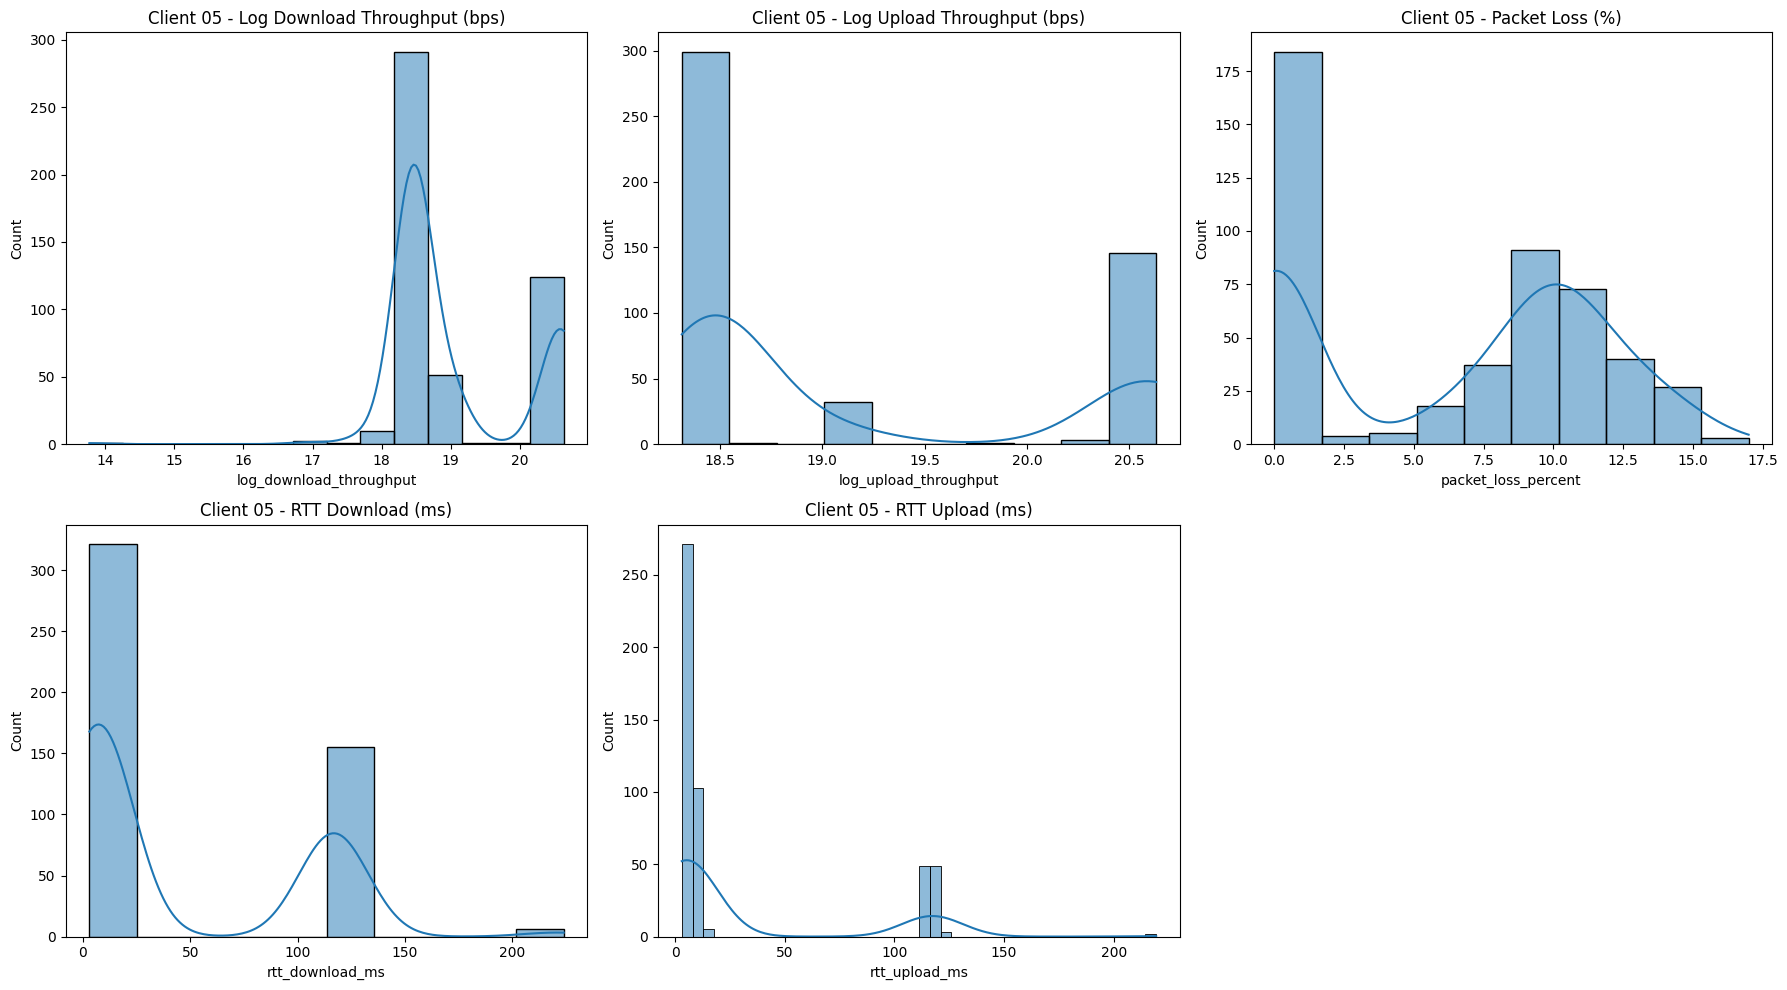

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    bins = np.histogram_bin_edges(client_05[metric], bins='auto')
    sns.histplot(client_05[metric], bins=bins, kde=True, ax=ax, edgecolor='black')
    ax.set_title(f'Client 05 - {plot_info[metric]}')

# Hide any unused subplots
for j in range(len(metrics), 6):
    row = j // 3
    col = j % 3
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()


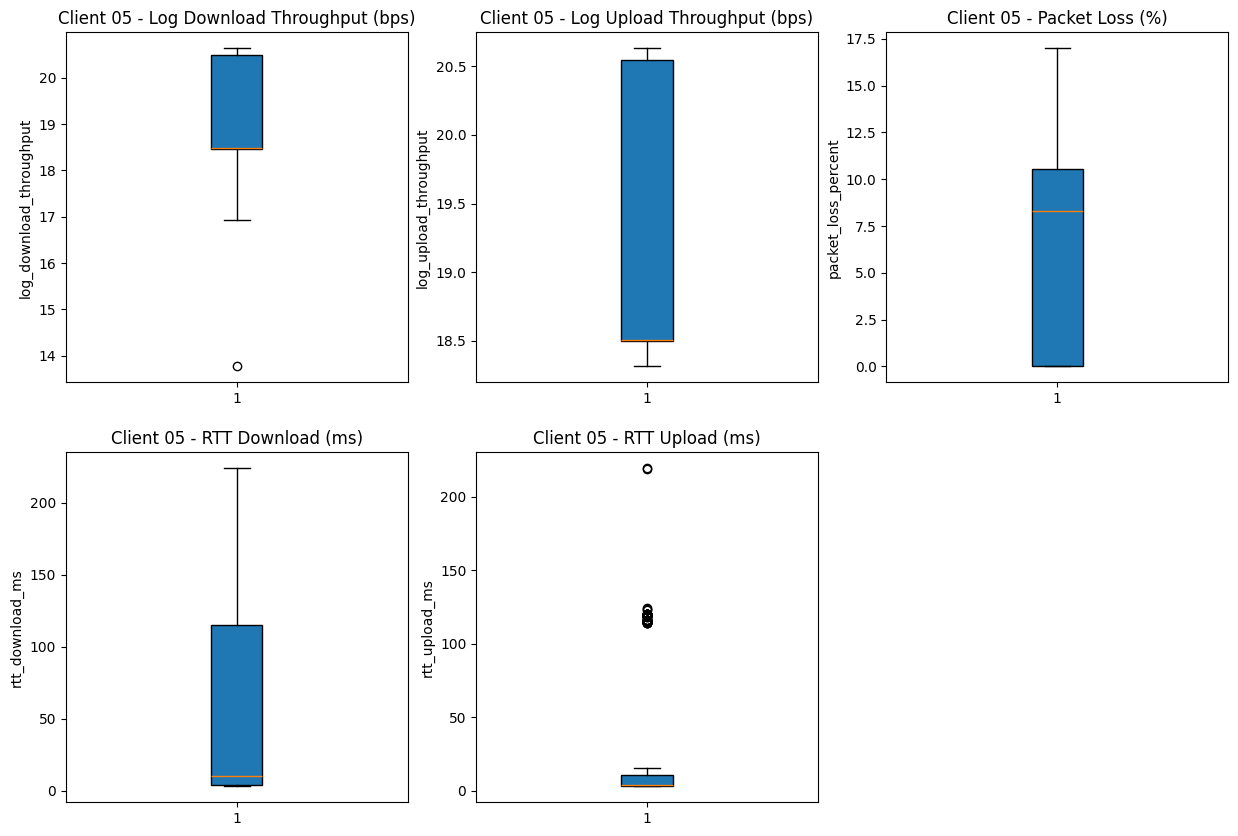

In [81]:
plt.figure(figsize=(15, 10))
for idx, i in enumerate(metrics):
    plt.subplot(2, 3, idx + 1)
    plt.boxplot(client_05[i], vert=True, patch_artist=True)
    plt.title(f'Client 05 - {plot_info[i]}')
    plt.ylabel(i)

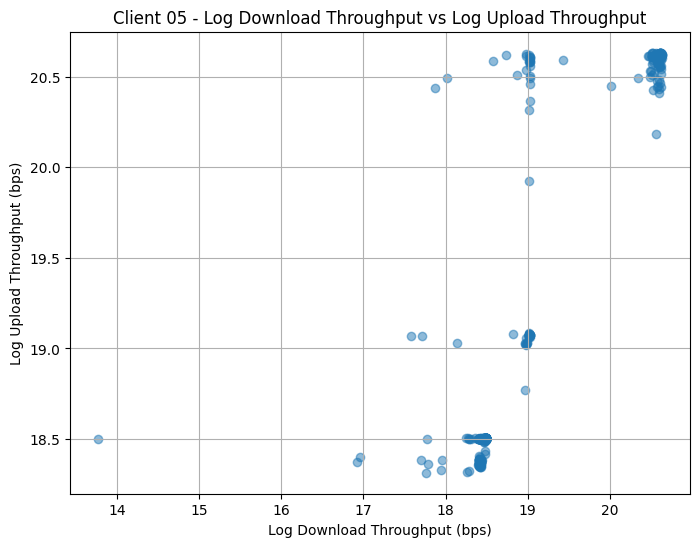

In [82]:
plt.figure(figsize=(8, 6))
plt.scatter(client_05['log_download_throughput'], client_05['log_upload_throughput'], alpha=0.5)
plt.title('Client 05 - Log Download Throughput vs Log Upload Throughput')
plt.xlabel('Log Download Throughput (bps)')
plt.ylabel('Log Upload Throughput (bps)')
plt.grid(True)
plt.show()


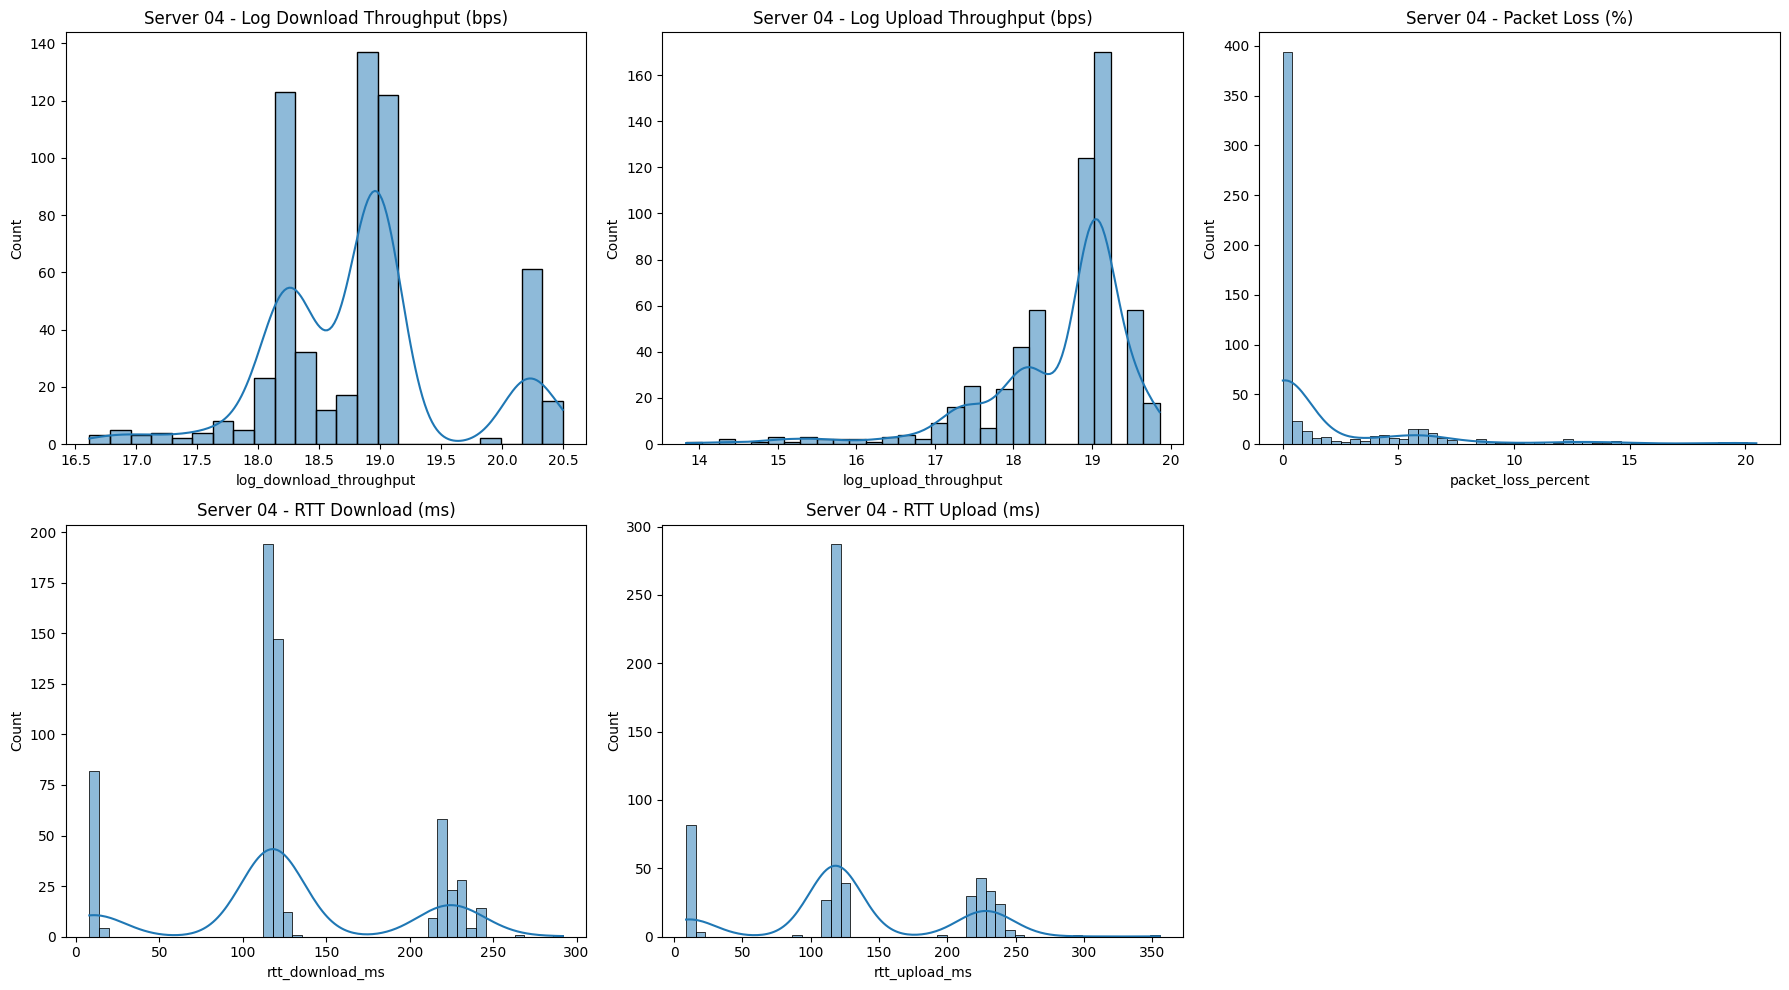

In [83]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    bins = np.histogram_bin_edges(server_04[metric], bins='auto')
    sns.histplot(server_04[metric], bins=bins, kde=True, ax=ax, edgecolor='black')
    ax.set_title(f'Server 04 - {plot_info[metric]}')

# Hide any unused subplots
for j in range(len(metrics), 6):
    row = j // 3
    col = j % 3
    axes[row, col].set_visible(False)
plt.tight_layout()
plt.show()

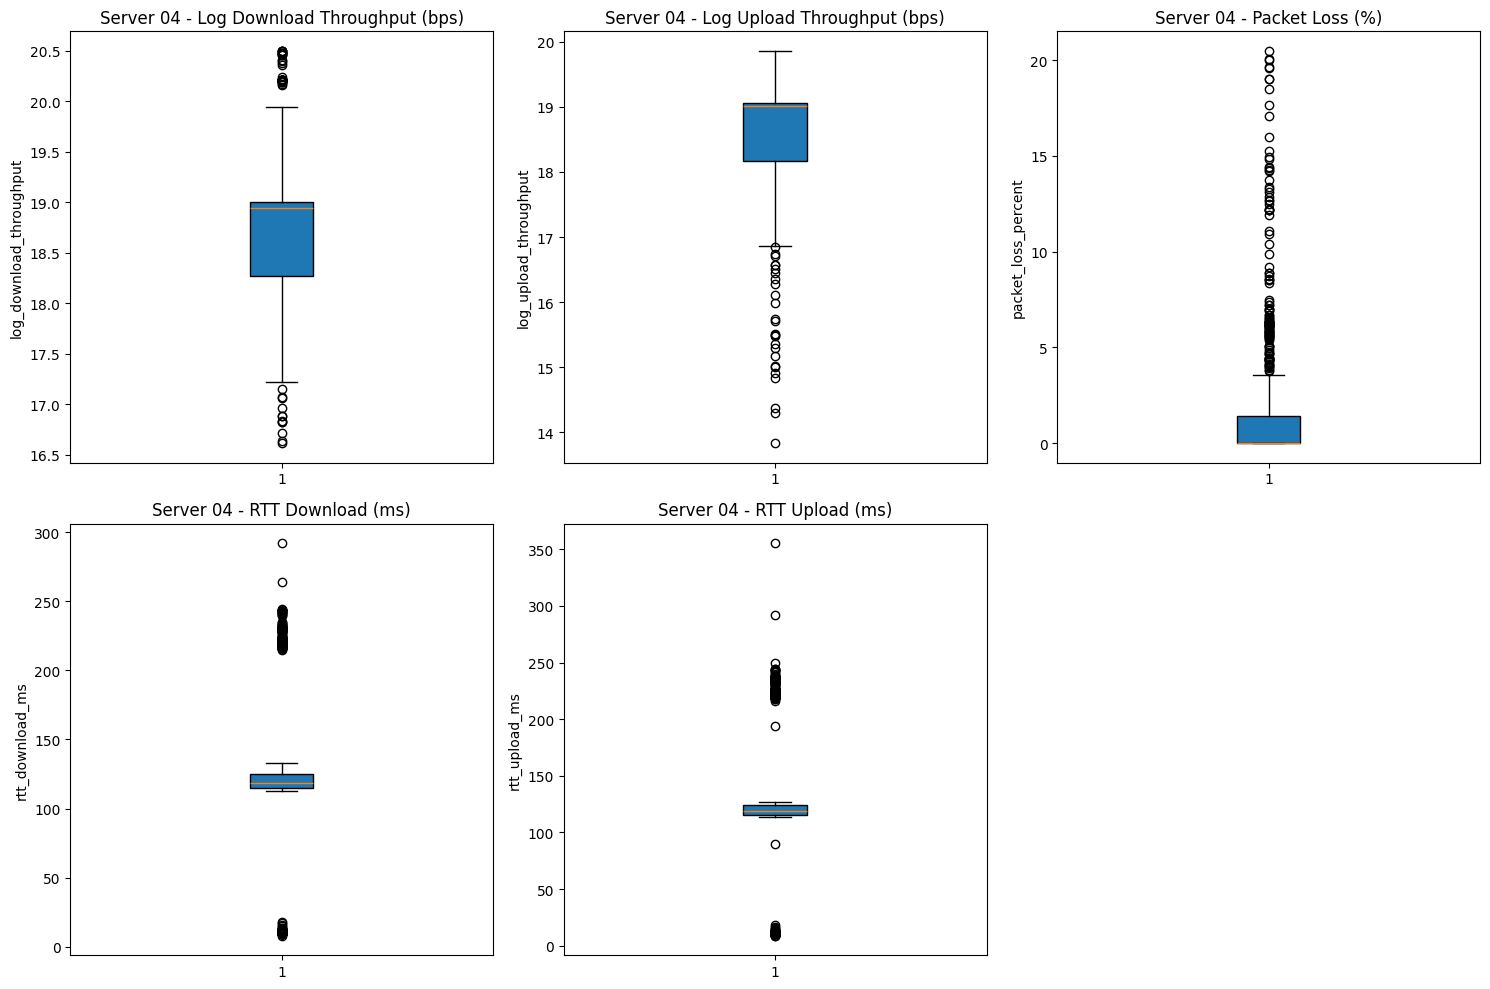

In [84]:
plt.figure(figsize=(15, 10))
for idx, i in enumerate(metrics):
    plt.subplot(2, 3, idx + 1)
    plt.boxplot(server_04[i], vert=True, patch_artist=True)
    plt.title(f'Server 04 - {plot_info[i]}')
    plt.ylabel(i)
plt.tight_layout()
plt.show()

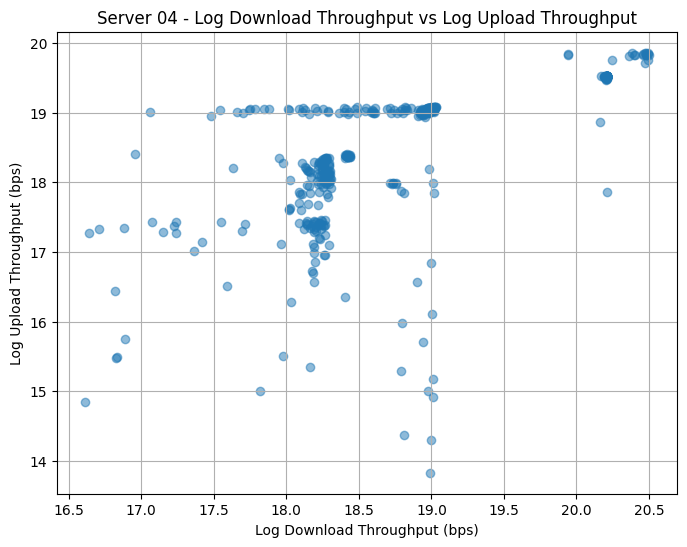

In [85]:
plt.figure(figsize=(8, 6))
plt.scatter(server_04['log_download_throughput'], server_04['log_upload_throughput'], alpha=0.5)
plt.title('Server 04 - Log Download Throughput vs Log Upload Throughput')
plt.xlabel('Log Download Throughput (bps)')
plt.ylabel('Log Upload Throughput (bps)')
plt.grid(True)
plt.show()